In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import cartopy.crs as ccrs
import shapely
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
import pandas as pd

from lmatools.io.LMA_h5_file import LMAh5File
from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Description of fields:

Storm_id: The ID of the storm identified. A storm is defined by a continuous period where cells were identified by TINT.
Scan: The scan number for the storm
Time: time of scan
Uid: The cell id

Isolated: Is the cell isolated?

Area: Area of cell in square km
Vol: 3d volume of cell in km^3
Grid_x: x location in terms of grid indices when using the grid specification supplied in the earlier code
Grid_y: y location in terms of grid indices when using the grid specification supplied in the earlier code
Lat: Cell center latitude
Lon: Cell center longitude

Max: Reflectivity maximum
Max_alt: The maximum altitude of the cell
Kdp_pct: Mean KDP in KDP column
Zdr_pct: Mean ZDR in ZDR column
Zhh_pct: Mean reflectivity in KDP column

`csu_dsd` - DSD parameter estimation via several different methodologies
`csu_kdp` - An FIR-based KDP estimation algorithm

Kdp_pet: KDP potential energy
Zdr_pet: ZDR potential energy
Zhh_pet: Reflectivity potential energy

In [2]:
from boto.s3.connection import S3Connection
from datetime import datetime, timedelta, date, time
def get_nexrad_keys(site, start=None, end=None):
    """
    Get generator of pyart radar objects for all nexrad data between two
    datetimes from Amazon S3.
    ----------
    site : string
        site code e.g. 'khgx'
    start : string
        datetime e.g. '20180101_000000'
    end : string
        same format as start

    """
    fmt = '%Y%m%d_%H%M%S'

    if start is None:
        start = datetime.utcnow() - timedelta(hours=1)
    else:
        start = datetime.strptime(start, fmt)
    if end is None:
        end = datetime.utcnow()
    else:
        end = datetime.strptime(end, fmt)
    if end < start:
        print('end datetime precedes start datetime')
        return

    site = site.upper()

    dates = []
    day_i = start
    while day_i < end:
        dates.append(day_i)
        day_i += timedelta(days=1)

    date_keys = [datetime.strftime(date, '%Y/%m/%d/' + site) for date in dates]

    conn = S3Connection(anon=True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    keys = [key for date_key in date_keys
            for key in list(bucket.list(date_key))
            if '.tar' not in str(key)]
#
#
    nkeys = []
    for i in np.arange(len(keys)):
        if str(keys[i])[-5:-1] != '_MDM':
            nkeys.append(keys[i])

    keys = nkeys
#
#
    if len(keys) == 0:
        print('Found 0 files.')
        return

    # Key ealier for keys before 'V06'
    if '.gz>' in str(keys[0]):
        key_fmt = site + '%Y%m%d_%H%M%S_V06.gz>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S.gz>'
    else:
        key_fmt = site + '%Y%m%d_%H%M%S_V06>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S>'

    key_dts = []
    for key in keys:
        try:
            key_dts.append(datetime.strptime(str(key).split('/')[-1], key_fmt))
        except ValueError:
            key_dts.append(
                datetime.strptime(str(key).split('/')[-1], key_fmt_earlier))
    key_dts = zip(keys, key_dts)
    keys = [key for key, dt in key_dts if dt > start and dt < end]
    print('Found', len(keys), 'keys.')
    return keys

In [3]:
keys = get_nexrad_keys('khgx', start='20170706_160000', end='20170706_170000')

Found 10 keys.


In [4]:
keys

[<Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_160154_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_160742_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_161526_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_162113_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_162700_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_163247_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_163835_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_164423_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_165011_V06>,
 <Key: noaa-nexrad-level2,2017/07/06/KHGX/KHGX20170706_165558_V06>]

In [5]:
radar = read_nexrad_key(keys[-1])

Text(0.5, 1.0, '')

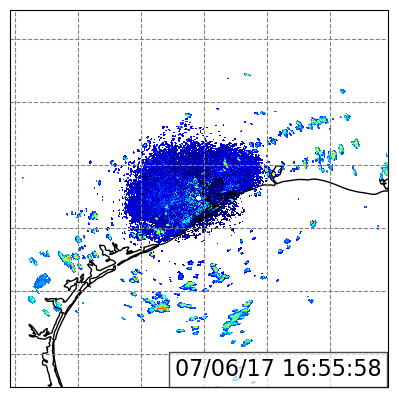

In [6]:
projection = ccrs.PlateCarree()
# fig, ax = plt.subplots(figsize=(12,10), dpi=100)
fig = plt.figure(figsize=(5,5), dpi=100)

d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
tt = datetime.combine(d,t)
elevations = radar.fixed_angle['data']

ax = fig.add_subplot(1,1,1, projection = projection)
ax.coastlines(resolution='10m')
ax.gridlines(color='gray', linestyle='--', draw_labels=False)

zoom = 3
ext = [ radar.longitude['data'][0] - zoom, radar.longitude['data'][0] + zoom, 
       radar.latitude['data'][0] - zoom, radar.latitude['data'][0] + zoom]
ax.set_extent(ext)

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',sweep=0, vmin=0, vmax=65, ax=ax, fig=fig,mask_outside=False, 
                     cmap='jet',colorbar_flag=False, embelish=False, alpha = 0.9)


td = fig.text(0.465, 0.147, tt.strftime("%m/%d/%y %H:%M:%S"),fontsize = 16,)
td.set_bbox(dict(facecolor='white', alpha=0.7))

# plt.setp( ax.get_xticklabels(), visible=False)
ax.set_title('')

# ax.text(-0.10, 0.55, 'Latitude (degree)', va='bottom', ha='center', rotation='vertical',rotation_mode='anchor',
#     transform=ax.transAxes, fontsize = 14)
# ax.text(0.5, -0.12, 'Longitude (degree)', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',
#     transform=ax.transAxes, fontsize = 14)


In [7]:
def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 401, 401),
        grid_limits=((0, 15000), (-200000,200000), (-200000, 200000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

# Let's write these grids to a temporary location so that we can reuse them.
# This might take a few minutes
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /tmp/tmpxmtqp14s
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [8]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [9]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000,
 'FLOW_MARGIN': 10000,
 'MAX_FLOW_MAG': 50,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 15,
 'ISO_THRESH': 8,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500}

In [10]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.2 minutes


In [11]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(20)

time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                      
0    0   2017-07-06 16:01:54.848  136.938    2.688 -95.7185  27.6987   16.0   
     1   2017-07-06 16:01:54.848  157.034    8.840 -95.5156  27.7535  119.0   
     2   2017-07-06 16:01:54.848  176.667   20.667 -95.3127  27.8619    9.0   
     3   2017-07-06 16:01:54.848  147.833   28.750 -95.6080  27.9330   24.0   
     4   2017-07-06 16:01:54.848  188.798   34.356 -95.1907  27.9790  104.0   
     5   2017-07-06 16:01:54.848  117.500   33.000 -95.9136  27.9674   10.0   
     6   2017-07-06 16:01:54.848  129.231   41.846 -95.8022  28.0490   13.0   
     7   2017-07-06 16:01:54.848  248.500   45.000 -94.5895  28.0771    6.0   
     8   2017-07-06 16:01:54.848   99.800   54.400 -96.0987  28.1550    5.0   
     9   2017-07-06 16:01:54.848  281.421   57.684 -94.2523  28.1923   19.0   
     10  2017-07-06 16:01:54.848  237.111   58.667 -94.7012  28.2033    9.0   
     11  2017-07-06 16:01:54.848  183.636   59.091 -95.2420  28.2038   11.0   
     12  2017-07-06 16:01:54.848   95.667   60.556 -96.1401  28.2176    9.0   
     13  2017-07-06 16:01:54.848  181.765   64.706 -95.2625  28.2577   17.0   
     14  2017-07-06 16:01:54.848  213.158   80.842 -94.9458  28.4016   19.0   
     15  2017-07-06 16:01:54.848   17.395   85.372 -96.9501  28.4246   43.0   
     16  2017-07-06 16:01:54.848  197.000   84.500 -95.1094  28.4287   18.0   
     17  2017-07-06 16:01:54.848   37.000  106.000 -96.7486  28.6161   21.0   
     18  2017-07-06 16:01:54.848  328.400  105.200 -93.7675  28.6111    5.0   
     19  2017-07-06 16:01:54.848   30.127  111.382 -96.8211  28.6602   55.0   

            vol        max  max_alt  isolated  
scan uid                                       
0    0     38.5  38.528515      6.0     False  
     1    352.0  47.862320      5.5     False  
     2     18.0  40.746407      4.5     False  
     3     73.0  42.991074      5.0      True  
     4    353.5  54.355770      7.0     False  
     5     22.5  37.095066      4.5      True  
     6     26.0  38.294792      4.5      True  
     7     10.5  36.533623      4.0      True  
     8      4.5  38.057632      4.5     False  
     9     51.0  43.763050      7.0      True  
     10    30.5  43.027313      6.0      True  
     11    27.0  41.785694      6.0     False  
     12    20.0  42.253120      4.5     False  
     13    52.0  47.353928      5.5     False  
     14    59.0  45.281483      5.0     False  
     15   140.0  46.852478      6.5      True  
     16    60.5  52.593666      6.5      True  
     17    56.0  43.036804      8.5     False  
     18     6.0  35.588963      3.5     False  
     19   216.0  47.411583      8.5     False

In [25]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:10]

uid
1      10
30     10
7      10
4      10
36      8
14      7
150     6
146     6
155     6
151     6
dtype: int64

In [13]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

Animating 1 frames
Frame: 0
Make sure ffmpeg is installed properly.


In [14]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

file does not exist.


In [28]:
# We can view the attributes of this cell throughout its lifetime
tracks_obj.tracks.xs('146', level='uid')

,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
scan,,,,,,,,,,
4,2017-07-06 16:27:00.342,40.889,99.111,-96.7066,28.5537,18.0,53.0,45.168465,5.0,False
5,2017-07-06 16:32:47.805,40.545,100.364,-96.7068,28.5627,22.0,59.0,43.640110,5.0,False
6,2017-07-06 16:38:35.180,40.414,101.586,-96.7173,28.5805,29.0,87.5,45.240540,5.0,True
7,2017-07-06 16:44:23.601,39.706,102.294,-96.7173,28.5805,17.0,50.0,41.785843,5.0,True
8,2017-07-06 16:50:11.028,39.667,103.000,-96.7174,28.5895,24.0,76.0,45.911190,8.5,False
9,2017-07-06 16:55:58.403,39.586,102.966,-96.7174,28.5895,29.0,79.0,43.807400,5.0,False


In [16]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

temporary directory removed


<bound method NDFrame.head of                             time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                      
0    0   2017-07-06 16:01:54.848  136.938    2.688 -95.7185  27.6987   16.0   
     1   2017-07-06 16:01:54.848  157.034    8.840 -95.5156  27.7535  119.0   
     2   2017-07-06 16:01:54.848  176.667   20.667 -95.3127  27.8619    9.0   
     3   2017-07-06 16:01:54.848  147.833   28.750 -95.6080  27.9330   24.0   
     4   2017-07-06 16:01:54.848  188.798   34.356 -95.1907  27.9790  104.0   
...                          ...      ...      ...      ...      ...    ...   
9    267 2017-07-06 16:55:58.403  352.889  332.889 -93.4793  30.6584    9.0   
     253 2017-07-06 16:55:58.403  376.885  337.346 -93.2277  30.6912   26.0   
     268 2017-07-06 16:55:58.403  383.909  336.818 -93.1545  30.6901   11.0   
     254 2017-07-06 16:55:58.403  391.333  338.333 -93.0812  30.6980    9.0   
     269 2017-07-06 16